<a href="https://colab.research.google.com/github/JoaoAlexandreFerreira/RNA/blob/main/Rede_neural_para_o_CILAMCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Código com o objetivo de montar uma Rede Neural Artificial para formar um poliômio que relacione a densidade em função da pressão.

A arquitetura inicial é a seguinte:


*   Duas entradas: Pressão e Salinidade;
*   Uma saída: Densidade.

Será realizado estudo da rede "perfeita", i.e., a rede com o menor erro relativo em função do número de camadas ocultas, número de neurônios ocultos, função de ativação e taxa de aprendizado.

A saber, as funções de ativação testadas serão:


1.   Sigmóide;
2.   Tangente Hipérbolica;
3.   Relu;
4.   LeakyRelu;

Com as seguintes taxas de aprendizado:



1.   0.01
2.   0.005
3.  0.001

Importando as bibliotecas necessárias

In [1]:
from keras.models import Sequential
from keras.layers import Dense
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.metrics import  MeanRelativeError
from sklearn.metrics import mean_absolute_error
from keras.initializers import Ones, GlorotNormal, he_normal, Zeros, Constant

tf.random.set_seed(231)

Definindo as funções e as taxas

In [2]:
funcoes = ['tanh', 'relu', 'sigmoid', 'LeakyReLU']
taxas = [0.005, 0.01, 0.05]

Função para definir o modelo e o treino do mesmo

In [3]:
def modelo_RNA(x, activation, nos, camadas_ocultas):
  modelo = Sequential()
  modelo.add(tf.keras.layers.Input(shape=(x.shape[1],)))
  #modelo.add(keras.layers.Dense(nos, activation='relu', input_shape=x.shape))
  for i in range(camadas_ocultas):
    modelo.add(keras.layers.Dense(nos, activation=activation, kernel_initializer=GlorotNormal()))
  modelo.add(keras.layers.Dense(1, activation= 'linear'))
  modelo.summary()

  return modelo

def padronizar_peso(modelo):
  for layer in modelo.layers:
    if isinstance(layer, Dense):
      weights, biases = layer.get_weights()
      weights_mean = weights.mean()
      weights_std = weights.std()
      weights = (weights - weights_mean) / weights_std
      layer.set_weights([weights, biases])
    return modelo

def treino_modelo(modelo, optimizer, loss, metrics, x_treino, y_treino, x_teste, y_teste, itr):
  modelo.compile(optimizer=optimizer, loss=loss, metrics=metrics)

  resultado = modelo.fit(x_treino, y_treino, epochs=itr, batch_size=5, verbose = 1, validation_data=(x_teste, y_teste))

  return resultado, modelo

def erro_relativo(y_pred, y_true):
  return np.mean(np.abs((y_true - y_pred) / y_true))

In [4]:
def custo_final(resultado):
    train_loss = resultado.history['loss']
    val_loss = resultado.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    return {'custo treino': train_loss[idx_min_val_loss], 'custo validação': val_loss[idx_min_val_loss]}

def plot_erro(resultado):
    treino_loss = resultado.history['loss']
    val_loss = resultado.history['val_loss']

    fig, ax = plt.subplots()
    ax.semilogy(treino_loss, label='Treino')
    ax.semilogy(val_loss, label='Validação')
    ax.set(title='Curvas de erro para o treino e a validação', xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()

Extraindo o dataset necessário

In [9]:
df = pd.read_excel('Densidade_temperatura_pressao_salinidade.xlsx')
#y = df['Densidade']
#x = df.drop('Demsodade', axis = 1)

#proporção de treino e validação
prop_treino = 0.8 #80% treino e 20% validação

indices = np.arange(len(df))
treino, val = train_test_split(indices, train_size = prop_treino, random_state = 30)

dados_treino = df.iloc[treino]
dados_validacao = df.iloc[val]

x_treino = dados_treino.drop('Densidade (kg/m3)', axis = 1); x_val = dados_validacao.drop('Densidade (kg/m3)', axis = 1)
y_treino = dados_treino['Densidade (kg/m3)']; y_val = dados_validacao['Densidade (kg/m3)']

x_treino = x_treino.values ; x_val = x_val.values; y_treino = y_treino.values; y_val = y_val.values
#Normalizando

scaler = MinMaxScaler()
x_treino_normalizado = scaler.fit_transform(x_treino)
x_val_normalizado = scaler.transform(x_val)


Para ver o melhor número de camadas ocultas e neuronios, é treinado com a função linear, assim:



*   Fixar o número de neuronios em 10;
*   Variar o número de camadas ocultos



In [10]:
erros = []
for i in range(2, 17):
  otimizador = tf.keras.optimizers.Adam(learning_rate = 0.01)
  nos = 10
  modelo = modelo_RNA(x_treino, 'linear', nos, i)
  modelo = padronizar_peso(modelo)

  resultado, modelo = treino_modelo(modelo, otimizador, 'mse', ['mae'], x_treino, y_treino, x_val, y_val, 330)

  y_pred = modelo.predict(x_val)

  erro = mean_absolute_error(y_val, y_pred)
  erros.append((i, erro))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                40        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 161 (644.00 Byte)
Trainable params: 161 (644.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/330
9/9 [==============================] - 1s 31ms/step - loss: 376.0542 - mae: 16.3910 - val_loss: 451.3859 - val_mae: 20.8855
Epoch 2/330
9/9 [==============================] - 0s 8ms/step - loss: 208.4171 - mae: 12.2236 - val_loss: 225.6850 - val_mae: 14.7800
Epoch 3/330

1/1 [==============================] - 0s 138ms/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 10)                40        
                                                                 
 dense_26 (Dense)            (None, 10)                110       
                                                                 
 dense_27 (Dense)            (None, 10)                110       
                                                                 
 dense_28 (Dense)            (None, 10)                110       
                                                                 
 dense_29 (Dense)            (None, 10)                110       
                                                                 
 dense_30 (Dense)            (None, 10)                110       
                                                                 
 

A saída de streaming foi truncada nas últimas 5000 linhas.
Epoch 275/330
9/9 [==============================] - 0s 10ms/step - loss: 2.0327e-04 - mae: 0.0115 - val_loss: 5.0436e-04 - val_mae: 0.0209
Epoch 276/330
9/9 [==============================] - 0s 11ms/step - loss: 2.6365e-04 - mae: 0.0134 - val_loss: 8.2872e-04 - val_mae: 0.0272
Epoch 277/330
9/9 [==============================] - 0s 10ms/step - loss: 4.9391e-04 - mae: 0.0189 - val_loss: 6.1385e-04 - val_mae: 0.0237
Epoch 278/330
9/9 [==============================] - 0s 9ms/step - loss: 4.3728e-04 - mae: 0.0182 - val_loss: 6.1028e-04 - val_mae: 0.0237
Epoch 279/330
9/9 [==============================] - 0s 11ms/step - loss: 3.9549e-04 - mae: 0.0155 - val_loss: 3.2693e-04 - val_mae: 0.0161
Epoch 280/330
9/9 [==============================] - 0s 11ms/step - loss: 2.3558e-04 - mae: 0.0118 - val_loss: 2.7364e-04 - val_mae: 0.0146
Epoch 281/330
9/9 [==============================] - 0s 11ms/step - loss: 3.8847e-04 - mae: 0.0168 - v

In [11]:
best_config = min(erros, key=lambda x: x[1])

print(f'Melhor configuração: {best_config[0]} camadas ocultas com erro relativo de {best_config[1]:.4f}')

Melhor configuração: 14 camadas ocultas com erro relativo de 0.0041


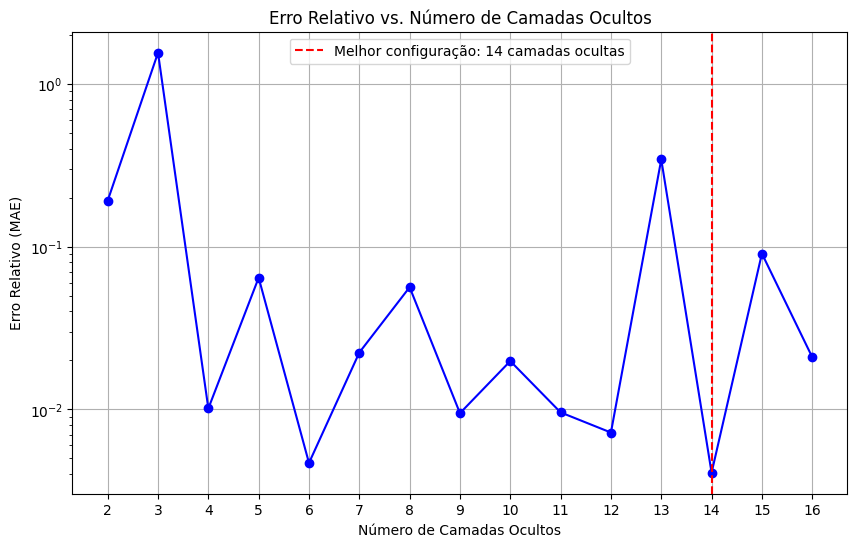

In [12]:
camadas, mae_errors = zip(*erros)
plt.figure(figsize=(10, 6))
plt.semilogy(camadas, mae_errors, marker='o', linestyle='-', color='b')
plt.xlabel('Número de Camadas Ocultos')
plt.ylabel('Erro Relativo (MAE)')
plt.title('Erro Relativo vs. Número de Camadas Ocultos')
plt.grid(True)
plt.xticks(camadas)
plt.axvline(x=best_config[0], color='r', linestyle='--', label=f'Melhor configuração: {best_config[0]} camadas ocultas')
plt.legend()
plt.show()

Feito isso, o passo seguinte é variar o número de nós ocultas, fixando o número de camadas

In [13]:
erros_n = []
for i in range(10, 70, 5):
  otimizador = tf.keras.optimizers.Adam(learning_rate = 0.01)
  modelo = modelo_RNA(x_treino, 'linear', i, best_config[0])
  modelo = padronizar_peso(modelo)

  resultado, modelo = treino_modelo(modelo, otimizador, 'mse', ['mae'], x_treino, y_treino, x_val, y_val, 330)

  y_pred = modelo.predict(x_val)

  erro = mean_absolute_error(y_val, y_pred)
  erros_n.append((i, erro))

A saída de streaming foi truncada nas últimas 5000 linhas.
Epoch 282/330
9/9 [==============================] - 0s 13ms/step - loss: 2.6851e-04 - mae: 0.0130 - val_loss: 2.0296e-04 - val_mae: 0.0137
Epoch 283/330
9/9 [==============================] - 0s 12ms/step - loss: 4.1798e-04 - mae: 0.0174 - val_loss: 0.0015 - val_mae: 0.0346
Epoch 284/330
9/9 [==============================] - 0s 13ms/step - loss: 6.9809e-04 - mae: 0.0209 - val_loss: 0.0013 - val_mae: 0.0317
Epoch 285/330
9/9 [==============================] - 0s 11ms/step - loss: 4.0983e-04 - mae: 0.0168 - val_loss: 0.0016 - val_mae: 0.0318
Epoch 286/330
9/9 [==============================] - 0s 13ms/step - loss: 0.0012 - mae: 0.0271 - val_loss: 0.0014 - val_mae: 0.0279
Epoch 287/330
9/9 [==============================] - 0s 12ms/step - loss: 8.4865e-04 - mae: 0.0239 - val_loss: 3.0762e-04 - val_mae: 0.0131
Epoch 288/330
9/9 [==============================] - 0s 12ms/step - loss: 2.7128e-04 - mae: 0.0132 - val_loss: 0.0023 - v

In [14]:
best_config_n = min(erros_n, key=lambda x: x[1])

print(f'Melhor configuração: {best_config_n[0]} nós ocultos com erro relativo de {best_config_n[1]:.4f}')

Melhor configuração: 10 nós ocultos com erro relativo de 0.0056


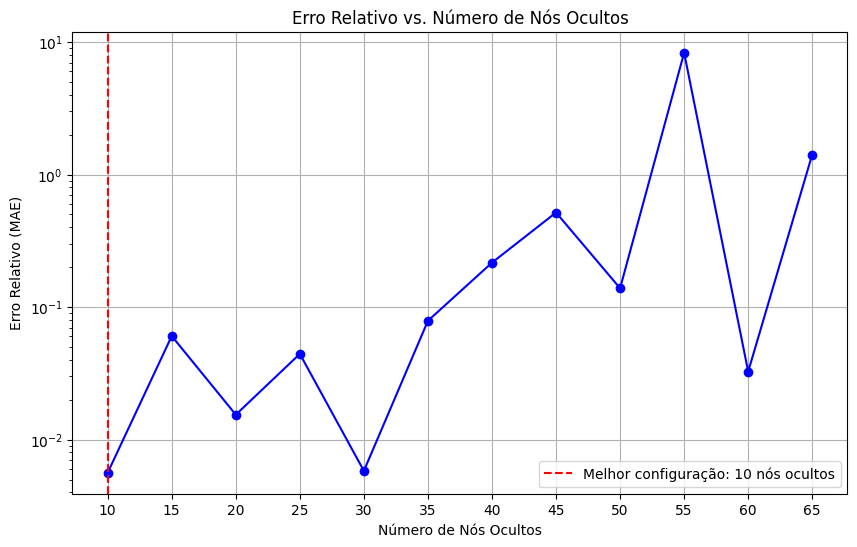

In [16]:
nos, mae_errors_n = zip(*erros_n)
plt.figure(figsize=(10, 6))
plt.semilogy(nos, mae_errors_n, marker='o', linestyle='-', color='b')
plt.xlabel('Número de Nós Ocultos')
plt.ylabel('Erro Relativo (MAE)')
plt.title('Erro Relativo vs. Número de Nós Ocultos')
plt.grid(True)
plt.xticks(nos)
plt.axvline(x=best_config_n[0], color='r', linestyle='--', label=f'Melhor configuração: {best_config_n[0]} nós ocultos')
plt.legend()
plt.show()

Por fim, deve-se analisar a rede em função da função de ativação e da taxa de aprendizado

In [17]:
resultados = list()
erros_relativos = list()
for i in funcoes:
  #modelo = modelo_RNA(x_treino, i, 40, 11)
  for j in taxas:
      otimizador = tf.keras.optimizers.Adam(learning_rate=j)
      modelo = modelo_RNA(x_treino, i, best_config_n[0], best_config[0])
      modelo = padronizar_peso(modelo)

      resultado, modelo = treino_modelo(modelo, 'adam', 'mse', ['mae'], x_treino, y_treino, x_val, y_val, 330)

      resultado = pd.DataFrame(resultado.history)
      resultados.append(resultado)

A saída de streaming foi truncada nas últimas 5000 linhas.
Epoch 278/330
9/9 [==============================] - 0s 14ms/step - loss: 4.4382e-05 - mae: 0.0054 - val_loss: 4.4454e-05 - val_mae: 0.0051
Epoch 279/330
9/9 [==============================] - 0s 11ms/step - loss: 5.8613e-05 - mae: 0.0064 - val_loss: 6.1058e-05 - val_mae: 0.0063
Epoch 280/330
9/9 [==============================] - 0s 13ms/step - loss: 5.8790e-05 - mae: 0.0063 - val_loss: 4.7019e-05 - val_mae: 0.0054
Epoch 281/330
9/9 [==============================] - 0s 14ms/step - loss: 3.4638e-05 - mae: 0.0049 - val_loss: 3.9078e-05 - val_mae: 0.0048
Epoch 282/330
9/9 [==============================] - 0s 11ms/step - loss: 4.4071e-05 - mae: 0.0057 - val_loss: 3.4643e-05 - val_mae: 0.0047
Epoch 283/330
9/9 [==============================] - 0s 11ms/step - loss: 6.0784e-05 - mae: 0.0068 - val_loss: 1.0136e-04 - val_mae: 0.0089
Epoch 284/330
9/9 [==============================] - 0s 11ms/step - loss: 8.5807e-05 - mae: 0.0079 - 

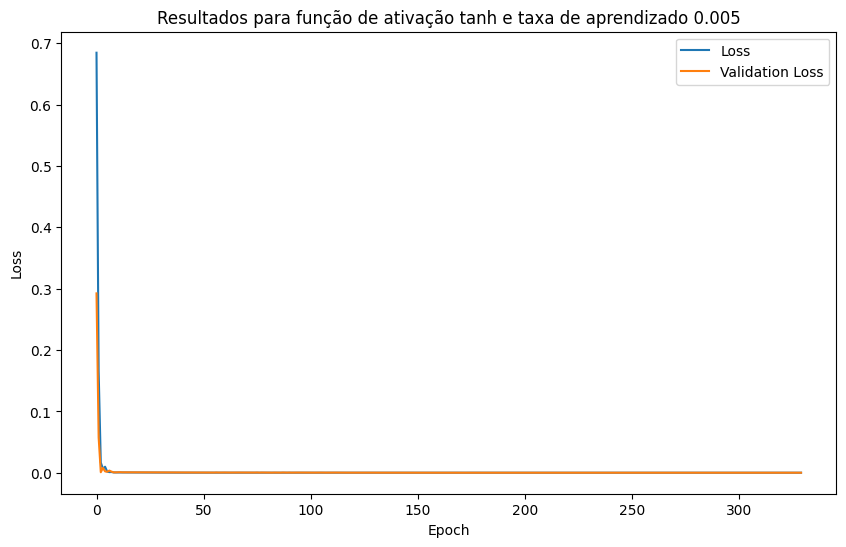

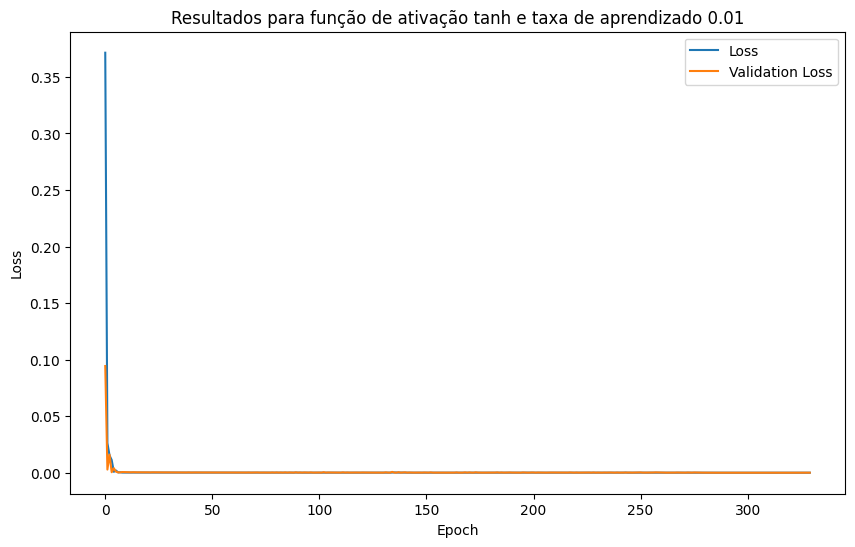

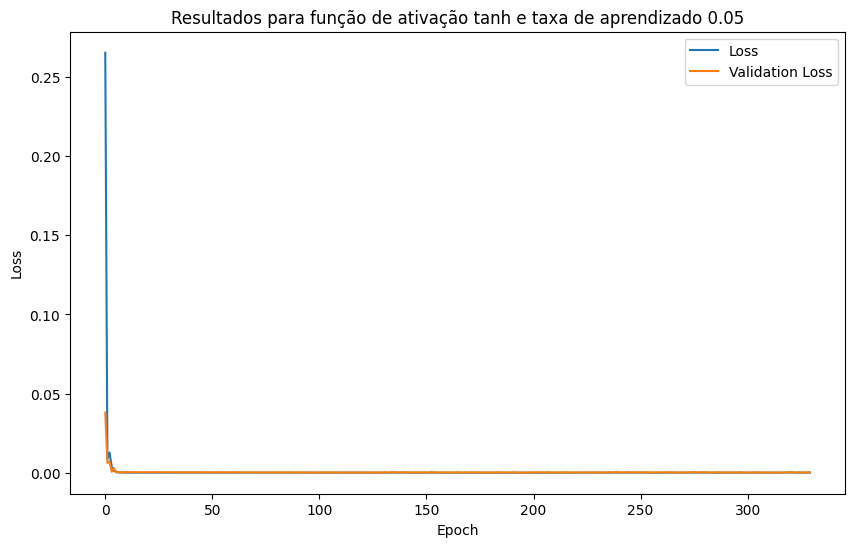

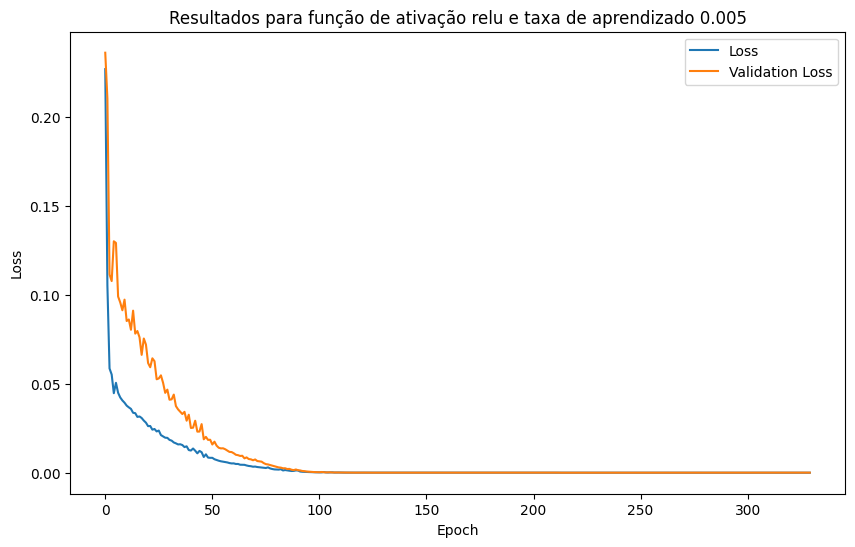

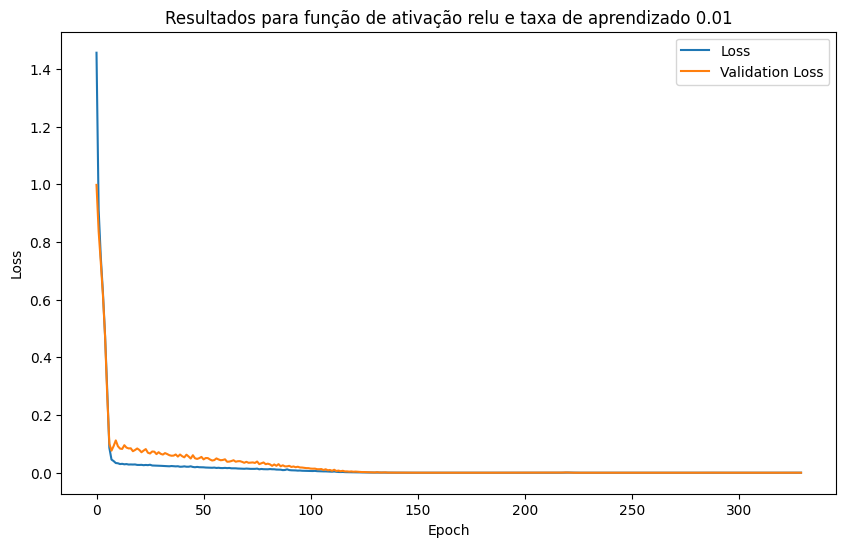

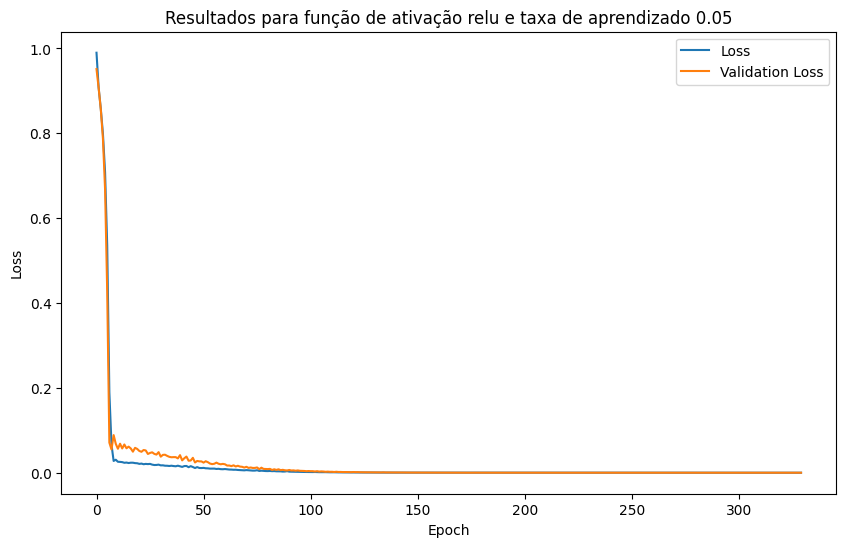

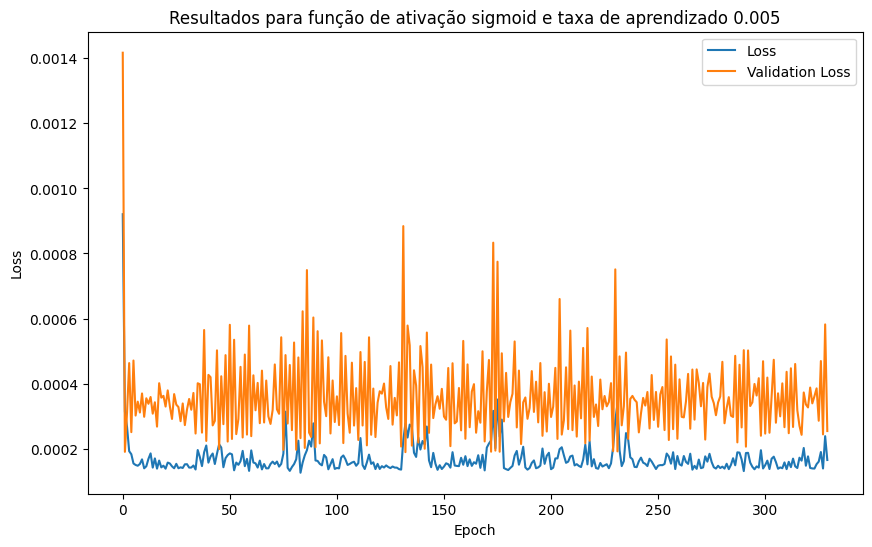

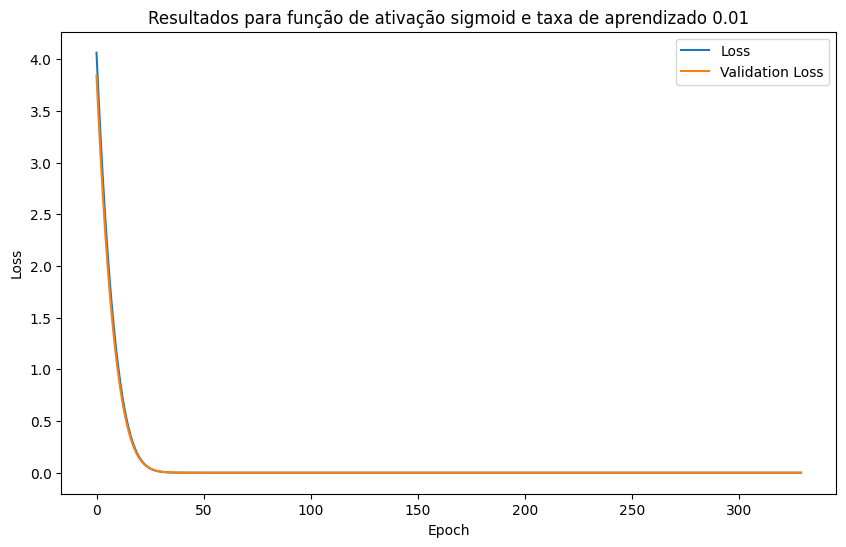

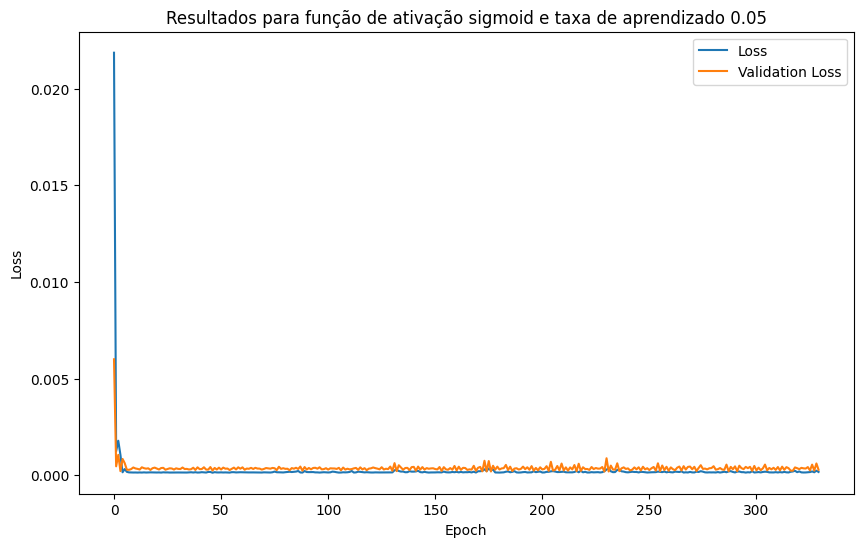

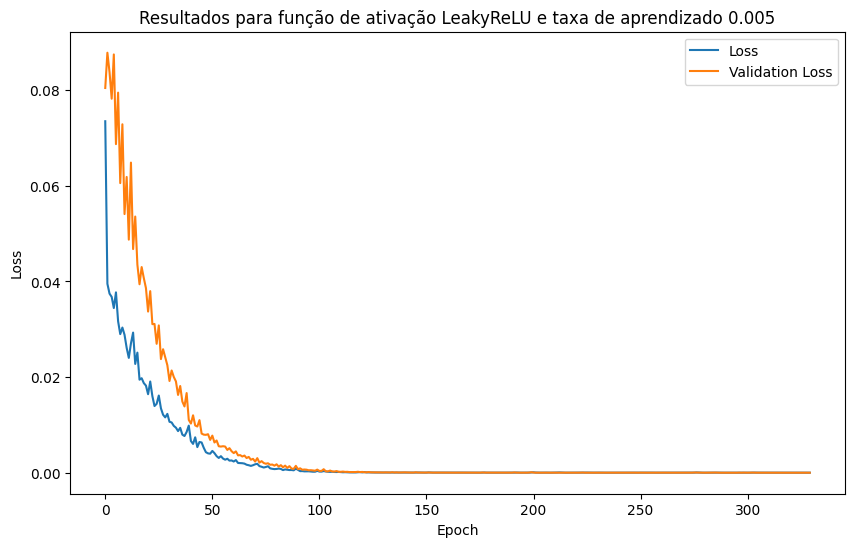

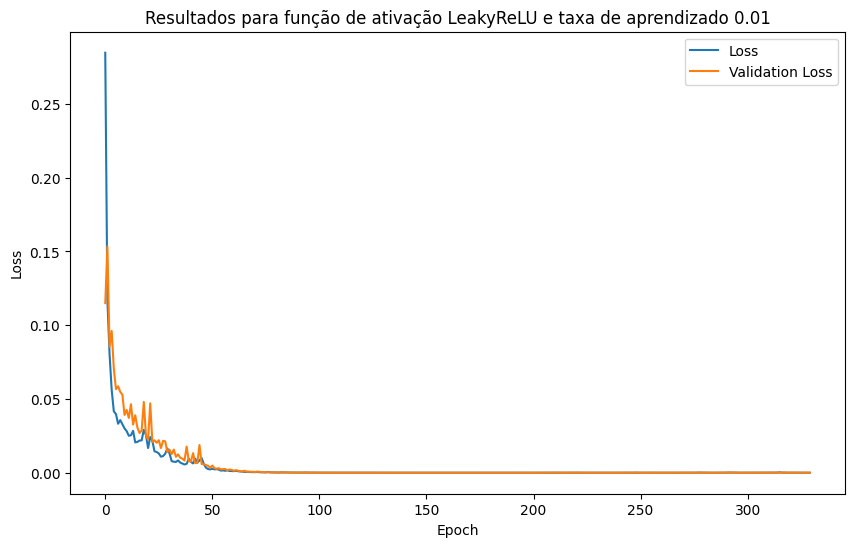

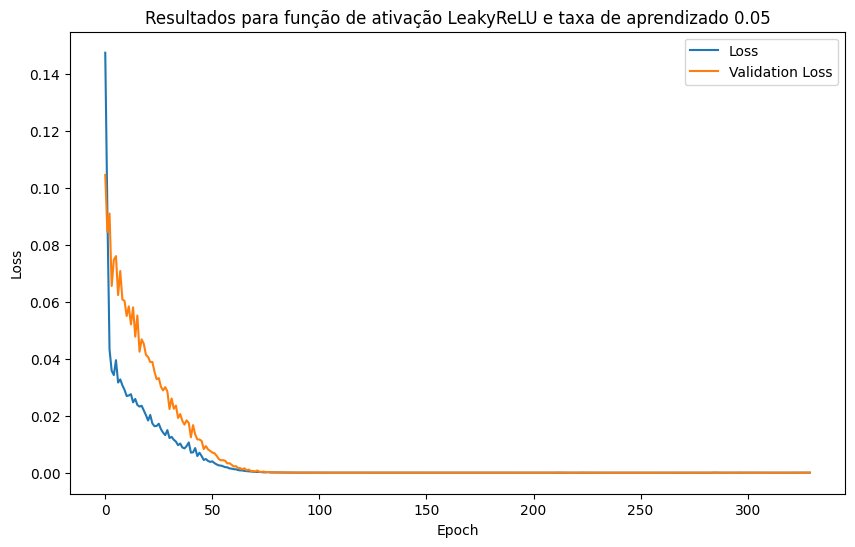

In [18]:
for i, funcao in enumerate(funcoes):
    for j, taxa in enumerate(taxas):
        resultado_df = resultados[i * len(taxas) + j]
        plt.figure(figsize=(10, 6))
        plt.plot(range(len(resultado_df)), resultado_df['loss'], label='Loss')
        plt.plot(range(len(resultado_df)), resultado_df['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Resultados para função de ativação {funcao} e taxa de aprendizado {taxa}')
        plt.legend()
        plt.show()